# 영화 관객수 예측 모델 개발
감독, 이름, 상영등급, 스태프 수 등의 정보를 이용하여 영화 관객 수를 예측하는 모델을 만들어 보는 것이다. <br>
데이콘에 교육 영상도 있으니 하나씩 천천히 이해하며 해보도록 하겠습니다.

## 1. 라이브러리 및 Data set 불러오기

In [1]:
import pandas as pd
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 데이터 불러오기
train = pd.read_csv('data/movies_train.csv')
test = pd.read_csv('data/movies_test.csv')
submission = pd.read_csv('data/submission.csv')

In [3]:
import platform

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
    print('Mac version')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
    print('Windows version')
elif platform.system() == 'Linux':
    path = "/usr/share/fonts/NanumFont/NanumGothicBold.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    plt.rc('font', family=font_name)
    print('Linux version')
else:
    print('Unknown system... sorry~~~~')


Linux version


## 2. 탐색적 자료분석
## Exploratory Data Analysis (EDA)
- EDA란 : 수집한 데이터가 들어왔을 때, 이를 다양한 각도에서 관찰하고 이해하는 과정입니다. 한마디로 데이터를 분석하기 전에 그래프나 통계적인 방법으로 자료를 직관적으로 바라보는 과정입니다.


+ title : 영화의 제목
+ distributor : 배급사
+ genre : 장르
+ release_time : 개봉일
+ time : 상영시간(분)
+ screening_rat : 상영등급
+ director : 감독이름
+ dir_prev_bfnum : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화에서의 평균 관객수(단 관객수가 알려지지 않은 영화 제외)
+ dir_prev_num : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화의 개수(단 관객수가 알려지지 않은 영화 제외)
+ num_staff : 스텝수
+ num_actor : 주연배우수
+ box_off_num : 관객수

In [85]:
train.head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,10,2012-11-22,96,청소년 관람불가,조병옥,0.00,0,91,2,23398
1,내부자들,(주)쇼박스,2,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,10,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083
3,나는 공무원이다,(주)NEW,11,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866
4,불량남녀,쇼박스(주)미디어플렉스,11,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387


In [5]:
movie_best = train.sort_values(ascending = False,by = 'box_off_num').head(10)

In [6]:
movie_best

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
372,국제시장,CJ 엔터테인먼트,드라마,2014-12-17,126,12세 관람가,윤제균,NaN,0,869,4,14262766
362,도둑들,(주)쇼박스,느와르,2012-07-25,135,15세 관람가,최동훈,2.564692e+06,3,462,10,12983841
530,7번방의 선물,(주)NEW,코미디,2013-01-23,127,15세 관람가,이환경,8.190495e+05,2,300,8,12811435
498,암살,(주)쇼박스,액션,2015-07-22,139,15세 관람가,최동훈,5.169479e+06,4,628,3,12706663
460,"광해, 왕이 된 남자",CJ 엔터테인먼트,드라마,2012-09-13,131,15세 관람가,추창민,1.552541e+06,2,402,3,12323595
122,변호인,(주)NEW,드라마,2013-12-18,127,15세 관람가,양우석,NaN,0,311,5,11374879
496,설국열차,CJ 엔터테인먼트,SF,2013-08-01,125,15세 관람가,봉준호,NaN,0,67,10,9350351
101,관상,(주)쇼박스,드라마,2013-09-11,139,15세 관람가,한재림,1.242778e+06,2,298,6,9135806
505,해적: 바다로 간 산적,롯데엔터테인먼트,SF,2014-08-06,130,12세 관람가,이석훈,1.843895e+06,3,868,2,8666208
476,수상한 그녀,CJ 엔터테인먼트,코미디,2014-01-22,124,15세 관람가,황동혁,2.781990e+06,2,437,5,8659725


위 결과는 관객수가 많은 10개 영화들을 출력해주었다

<AxesSubplot:xlabel='num_staff', ylabel='box_off_num'>

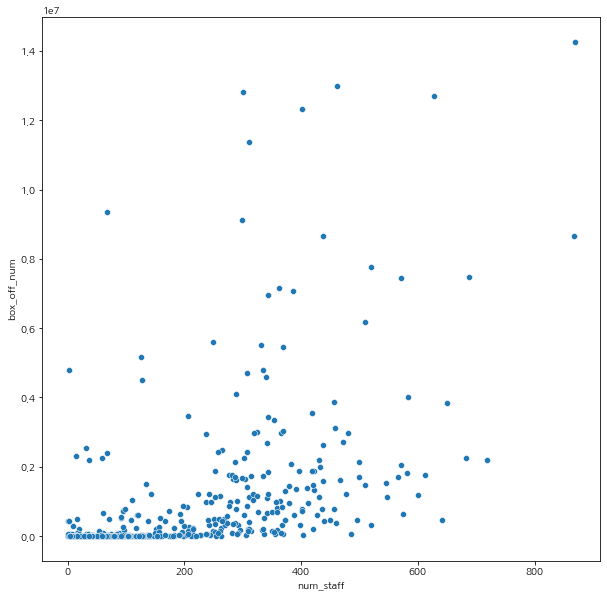

In [7]:
plt.figure(figsize=[10,10])
sns.scatterplot(data=train, x='num_staff', y = 'box_off_num')

위 결과는 관객수와 스태프수에 대해 그래프를 그려 봤는데 스탭수가 많으면 관객수가 조금 많은거 같다.

<AxesSubplot:xlabel='time', ylabel='box_off_num'>

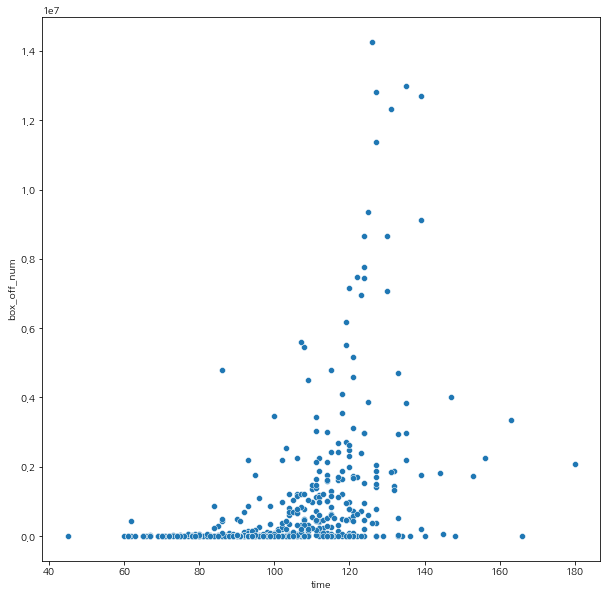

In [8]:
plt.figure(figsize=[10,10])
sns.scatterplot(data=train, x='time', y = 'box_off_num')

상영시간과 관객수 그래프를 보면 시간 120~140분 사이에 관객수가 많은걸 볼수있다

<AxesSubplot:xlabel='genre', ylabel='box_off_num'>

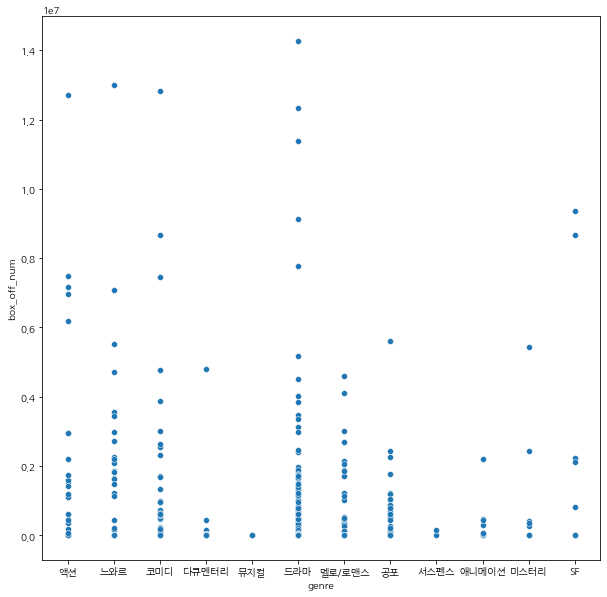

In [9]:
plt.figure(figsize=[10,10])
sns.scatterplot(data=train, x='genre', y = 'box_off_num')

장르와 관객수의 그래프이다.

<AxesSubplot:xlabel='num_actor', ylabel='box_off_num'>

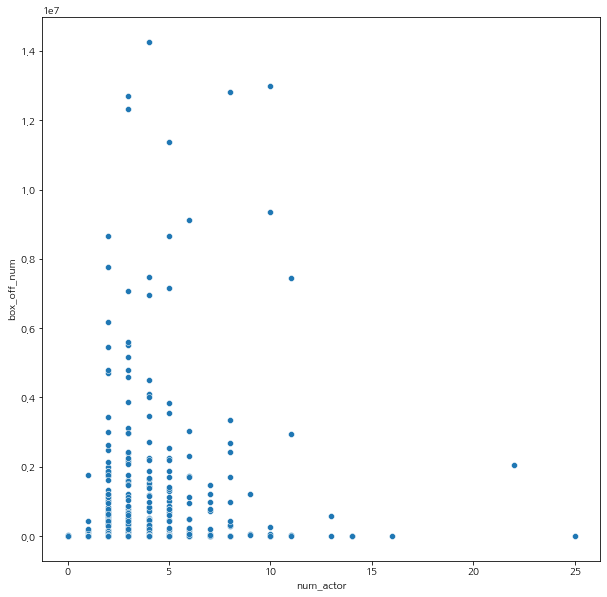

In [80]:
plt.figure(figsize=[10,10])
sns.scatterplot(data=train, x='num_actor', y = 'box_off_num')

주연 배우와 관객수 그래프이다.

In [10]:
train[['title','box_off_num']].head()

,title,box_off_num
0,개들의 전쟁,23398
1,내부자들,7072501
2,은밀하게 위대하게,6959083
3,나는 공무원이다,217866
4,불량남녀,483387


In [11]:
test.head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
0,용서는 없다,시네마서비스,느와르,2010-01-07,125,청소년 관람불가,김형준,3.005290e+05,2,304,3
1,아빠가 여자를 좋아해,(주)쇼박스,멜로/로맨스,2010-01-14,113,12세 관람가,이광재,3.427002e+05,4,275,3
2,하모니,CJ 엔터테인먼트,드라마,2010-01-28,115,12세 관람가,강대규,4.206611e+06,3,419,7
3,의형제,(주)쇼박스,액션,2010-02-04,116,15세 관람가,장훈,6.913420e+05,2,408,2
4,평행 이론,CJ 엔터테인먼트,공포,2010-02-18,110,15세 관람가,권호영,3.173800e+04,1,380,1


In [12]:
submission.head()

,title,box_off_num
0,용서는 없다,0
1,아빠가 여자를 좋아해,0
2,하모니,0
3,의형제,0
4,평행 이론,0


데이터 불러오기를 해서 보자. train 데이터는 모델 학습을 위한 데이터이다. test데이터는 관객수가 없는 데이터이고, submission 데이터는 제출을 위한 품을 제공하는 데이터로 test 데이터와 index가 같다고 한다.

#### 함수 shape를 사용하여 행의 개수, 열의 개수를 확인 할 수 있다.

In [13]:
print(train.shape)
print(test.shape)
print(submission.shape)

(600, 12)
(243, 11)
(243, 2)


##### 함수 info는 데이터의 column별 정보를 알려주는 함수이다. 비어있지 않은 값(non-null) 개수, column의 타입은 무엇인지도 알려준다.
 - type의 종류 : int(정수), float(실수), object(문자열), 등등 (date, ...)

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           600 non-null    object 
 1   distributor     600 non-null    object 
 2   genre           600 non-null    object 
 3   release_time    600 non-null    object 
 4   time            600 non-null    int64  
 5   screening_rat   600 non-null    object 
 6   director        600 non-null    object 
 7   dir_prev_bfnum  270 non-null    float64
 8   dir_prev_num    600 non-null    int64  
 9   num_staff       600 non-null    int64  
 10  num_actor       600 non-null    int64  
 11  box_off_num     600 non-null    int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 56.4+ KB


위 train데이터를 보면 dir_prev_dfnum은 270개가 채워져 있고 나머지 330개는 채워지지 않았다는것을 알수 있다.

In [15]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           243 non-null    object 
 1   distributor     243 non-null    object 
 2   genre           243 non-null    object 
 3   release_time    243 non-null    object 
 4   time            243 non-null    int64  
 5   screening_rat   243 non-null    object 
 6   director        243 non-null    object 
 7   dir_prev_bfnum  107 non-null    float64
 8   dir_prev_num    243 non-null    int64  
 9   num_staff       243 non-null    int64  
 10  num_actor       243 non-null    int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 21.0+ KB


위 test데이터도 보면 dir_prev_dfnum은 107개가 채워져 있고 나머지 채워지지 않았다는것을 알수 있다.

## groupby함수로 그룹을 만들수 있다. 

In [16]:
train[['genre', 'box_off_num']].groupby('genre').mean().sort_values('box_off_num')

,box_off_num
genre,
뮤지컬,6.627000e+03
다큐멘터리,6.717226e+04
서스펜스,8.261100e+04
애니메이션,1.819267e+05
멜로/로맨스,4.259680e+05
미스터리,5.275482e+05
공포,5.908325e+05
드라마,6.256898e+05
코미디,1.193914e+06


genre,box_off_num를 genre로 그룹바이한후 mean으로 평균을 산출해서 sort_values로 정렬해준다.

위 관객수로만 보면 액션 느와르가 가장 인기가 좋은것을 확인 할 수 있다.

In [17]:
train.describe()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
count,600.000000,2.700000e+02,600.000000,600.000000,600.000000,6.000000e+02
mean,100.863333,1.050443e+06,0.876667,151.118333,3.706667,7.081818e+05
std,18.097528,1.791408e+06,1.183409,165.654671,2.446889,1.828006e+06
min,45.000000,1.000000e+00,0.000000,0.000000,0.000000,1.000000e+00
25%,89.000000,2.038000e+04,0.000000,17.000000,2.000000,1.297250e+03
50%,100.000000,4.784236e+05,0.000000,82.500000,3.000000,1.259100e+04
75%,114.000000,1.286569e+06,2.000000,264.000000,4.000000,4.798868e+05
max,180.000000,1.761531e+07,5.000000,869.000000,25.000000,1.426277e+07


### corr함수(correlation coefficient) 상관계수를 확인하는 함수 

In [18]:
train.corr()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
time,1.000000,0.264675,0.306727,0.623205,0.114153,0.441452
dir_prev_bfnum,0.264675,1.000000,0.131822,0.323521,0.083818,0.283184
dir_prev_num,0.306727,0.131822,1.000000,0.450706,0.014006,0.259674
num_staff,0.623205,0.323521,0.450706,1.000000,0.077871,0.544265
num_actor,0.114153,0.083818,0.014006,0.077871,1.000000,0.111179
box_off_num,0.441452,0.283184,0.259674,0.544265,0.111179,1.000000


## 위 상관계수를 보면 숫자형태로 보는것은 직관적이지 않기 때문에 시각적으로 보겠습니다.

In [19]:
train[['genre','num_staff','box_off_num']].groupby('genre').mean().sort_values('box_off_num')

,num_staff,box_off_num
genre,,
뮤지컬,2.200000,6.627000e+03
다큐멘터리,17.849462,6.717226e+04
서스펜스,111.000000,8.261100e+04
애니메이션,44.619048,1.819267e+05
멜로/로맨스,135.782051,4.259680e+05
미스터리,117.352941,5.275482e+05
공포,176.380952,5.908325e+05
드라마,164.484163,6.256898e+05
코미디,209.075472,1.193914e+06


In [20]:
train_genre = train[['genre', 'box_off_num']].groupby('genre').mean().sort_values('box_off_num')

In [21]:
train_genre

,box_off_num
genre,
뮤지컬,6.627000e+03
다큐멘터리,6.717226e+04
서스펜스,8.261100e+04
애니메이션,1.819267e+05
멜로/로맨스,4.259680e+05
미스터리,5.275482e+05
공포,5.908325e+05
드라마,6.256898e+05
코미디,1.193914e+06


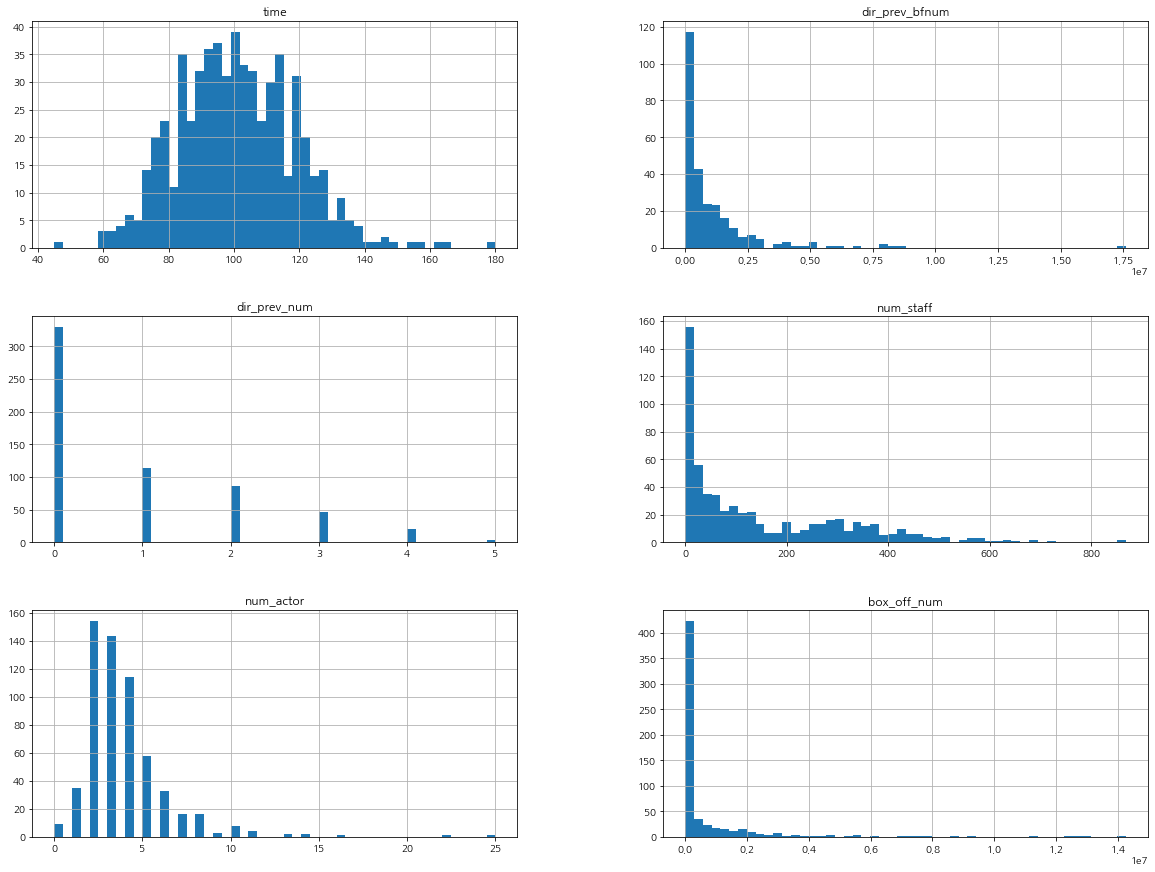

In [23]:
# 히스토그램
import matplotlib.pyplot as plt
%matplotlib inline

train.hist(bins = 50, figsize = (20,15))
plt.show()

<AxesSubplot:>

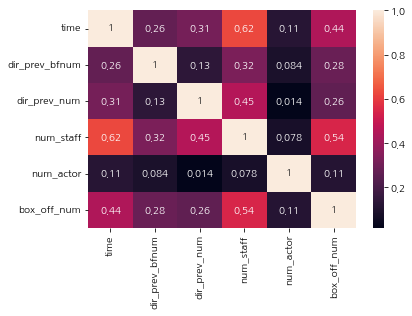

In [24]:
sns.heatmap(train.corr(), annot = True)

## 3. 데이터 전처리
## Data Cleansing & Pre-Processing  

### isna함수는 결측치 여부를 확인해준다. 결측치면 True, 아니면 False로 확인된다.

In [25]:
train.isna().head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,False,False,False,False,False,False,False,True,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False


이렇게 보면 결측치를 확인하기 어렵다. 여기서 sum함수를 이용해 확인해보자.

In [26]:
train.isna().sum()

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    330
dir_prev_num        0
num_staff           0
num_actor           0
box_off_num         0
dtype: int64

여기서 330개가 어떻게 나왔는지 알아보자. True는 1로 인식되고 False는 영어로 인식되기 때문에 위 결과가 나온것으로 알면된다.

In [27]:
test.isna().head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
0,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False


In [28]:
test.isna().sum()

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    136
dir_prev_num        0
num_staff           0
num_actor           0
dtype: int64

test데이터도 마찬가지로 확인해보면 136개의 결측값을 확인 할 수있다.

### fillna함수 결측치를 채울수 있는 함수.

In [29]:
train['dir_prev_bfnum']

0             NaN
1      1161602.50
2       220775.25
3        23894.00
4            1.00
          ...    
595       3833.00
596     496061.00
597           NaN
598           NaN
599           NaN
Name: dir_prev_bfnum, Length: 600, dtype: float64

In [30]:
train['dir_prev_bfnum'].fillna(0)

0            0.00
1      1161602.50
2       220775.25
3        23894.00
4            1.00
          ...    
595       3833.00
596     496061.00
597          0.00
598          0.00
599          0.00
Name: dir_prev_bfnum, Length: 600, dtype: float64

NaN이 0으로 바뀌는 것을 볼 수 있다. 다음 추가적으로 저장을 해주어야 하는 것이있다. inplace = True를 추가해줄것이다.

In [31]:
train.isna().sum()

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    330
dir_prev_num        0
num_staff           0
num_actor           0
box_off_num         0
dtype: int64

위 결측값 설정을 해주었지만 결측값이 계속 나온다. 이래서 저장을 해둔다 생각하고 inplace = True를 추가해서 보자.

In [32]:
train['dir_prev_bfnum'].fillna(0, inplace = True)

In [33]:
train.isna().sum()

title             0
distributor       0
genre             0
release_time      0
time              0
screening_rat     0
director          0
dir_prev_bfnum    0
dir_prev_num      0
num_staff         0
num_actor         0
box_off_num       0
dtype: int64

NaN 0으로 잘 설정이 되었다. 이것과 동일하게 test데이터도 같은 방법으로 설정해주자.

In [34]:
test['dir_prev_bfnum'].fillna(0, inplace = True)

In [35]:
test.isna().sum()

title             0
distributor       0
genre             0
release_time      0
time              0
screening_rat     0
director          0
dir_prev_bfnum    0
dir_prev_num      0
num_staff         0
num_actor         0
dtype: int64

## 여기까지 전처리 작업을 해보았다.

## 4. 변수 선택 및 모델 구축
## Feature Engineering & Initial Modeling  

In [36]:
model = lgb.LGBMRegressor(random_state=777, n_estimators=1000)

random_state=777은 어느 pc에서도 결과값이 같게 나오게 고정시켜준다고 이해를 하자. n_estimators은 순차적으로 만드는 모델을 1000번 반복해서 만들겟다는 뜻이라 생각하자.

In [37]:
features = ['time', 'dir_prev_num', 'num_staff', 'num_actor']
target = ['box_off_num']

이제 독립변수(features)와 종속변수(target)를 만들어주자.

독립변수,종속변수 설명 링크 : https://www.scienceall.com/%EB%8F%85%EB%A6%BD%EB%B3%80%EC%88%98independent-variable/

In [38]:
X_train, X_test, y_train = train[features], test[features], train[target]

X,y를 이제 tarin,test에 변수들을 저장해주도록 하자. 

In [39]:
model.fit(X_train, y_train)

LGBMRegressor(n_estimators=1000, random_state=777)

모델을 학습시켜주자.

In [40]:
singleLGBM = submission.copy()

In [41]:
singleLGBM.head()

,title,box_off_num
0,용서는 없다,0
1,아빠가 여자를 좋아해,0
2,하모니,0
3,의형제,0
4,평행 이론,0


In [42]:
singleLGBM['box_off_num'] = model.predict(X_test)

In [43]:
singleLGBM.head()

,title,box_off_num
0,용서는 없다,2.817995e+06
1,아빠가 여자를 좋아해,3.753772e+05
2,하모니,-5.693243e+05
3,의형제,1.581189e+06
4,평행 이론,-5.277806e+05


많이 잘못 됬다는것을 볼 수 있다. 관객수가 음수값이 나올수가 없는데 음수가 나오는것을 확인할수있다. 이 모델은 성능이 별로 안좋은거 같다. 다른 모델로 넘어가보도록 하자.

## k-fold 교차검증 (k-fold cross validation)
이해하기 쉬운 링크 : https://huidea.tistory.com/30

In [44]:
from sklearn.model_selection import KFold

In [45]:
k_fold = KFold(n_splits=5, shuffle=True, random_state=777)

n_splits = 5은 몇 등분 할지 설정후 shuffle = True는 섞어서 5등분을 시킨다는 의미이다. 섞는 이유는 순서에 대한 영향력이 있을수 있기에 섞어준다고 생각하자.

In [46]:
for train_idx, val_idx in k_fold.split(X_train):
    print(len(train_idx), len(val_idx))
    break

480 120


위 결과를 보면 5등분이 되었다는 것을 알수있다. train_idx은 600개중 4등분인 480개 val_idx는 120개로 나눠져있다.  

In [47]:
model = lgb.LGBMRegressor(random_state=777, n_estimators=1000)

models = [] # 모델을 담을 바구니라 생각하자.

for train_idx, val_idx in k_fold.split(X_train):
    x_t = X_train.iloc[train_idx]
    y_t = y_train.iloc[train_idx]
    x_val = X_train.iloc[val_idx]
    y_val = y_train.iloc[val_idx]
    
    models.append(model.fit(x_t, y_t, eval_set=(x_val, y_val), early_stopping_rounds=100, verbose = 100))

Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 2.70572e+12
Early stopping, best iteration is:
[6]	valid_0's l2: 2.45438e+12
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 3.90847e+12
Early stopping, best iteration is:
[33]	valid_0's l2: 3.72825e+12
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 3.50344e+12
Early stopping, best iteration is:
[8]	valid_0's l2: 2.58737e+12
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 1.45977e+12
Early stopping, best iteration is:
[11]	valid_0's l2: 1.26226e+12
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 1.77214e+12
Early stopping, best iteration is:
[22]	valid_0's l2: 1.57631e+12


early_stopping_rounds=100은 100번의 과정동안 오차율이 감소되지 않으면 멈춰라라는 명령어이다. 그이상하면 과적합이 발생하기 때문에 설정해 준다고 생각하자.위 결과를 보면 [100],[6],[33]...등등 보인다. [100]은 100번과정을 다하였다는 뜻이고. [6]은 6번이상 해도 오차율이 감소하지 않아 멈춘것을 볼 수 있다.<br>
verbose = 100 은 우리가 1000번 학습을 하는데 100번째 모델마다 출력값을 산출해 달라라는 뜻이라 이해하자.

In [48]:
models

[LGBMRegressor(n_estimators=1000, random_state=777),
 LGBMRegressor(n_estimators=1000, random_state=777),
 LGBMRegressor(n_estimators=1000, random_state=777),
 LGBMRegressor(n_estimators=1000, random_state=777),
 LGBMRegressor(n_estimators=1000, random_state=777)]

In [49]:
preds = []
for model in models:
    preds.append(model.predict(X_test))
len(preds)

5

preds 배열을 만들어서 만들어두었던 모델들의 예측값을 저장해준다

In [50]:
preds

[array([3367422.08211024,  961138.88337016, 1097929.67851313,
        2097270.81999921,  781476.31131047,  123133.23396977,
          84085.01896248,  199222.92670303,  124854.97973097,
        1072684.78820647,  657040.55769984, 1644701.47160779,
         924735.72080619,  191699.58415836,  723218.39948755,
        2395613.42888462,  113180.54906592, 1882765.92812296,
          97286.47282983,  417270.42113431,  161482.3367577 ,
          63495.73363115,  598057.42337284,  249411.25868881,
         308424.71884273, 1319518.60852241,  202273.52740684,
        1076683.13768137,  491636.41945325,  183406.6380314 ,
        1740233.45816734,   86696.17528125,  440430.29773088,
        2040944.13061099,  113375.45695331,  531746.29484356,
         106207.35971699,  169560.79581187,  158101.0895316 ,
          95037.29701059,  466355.50624629,  197548.63265325,
         198810.0901353 ,  682743.4340129 ,  679265.22397749,
         617812.91125278,  219182.85833837,   83712.10602149,
        

이렇게 예측값들이 5세트가 있는것을 볼 수 있다.

In [51]:
import numpy as np # 예측값의 평균을 구하기위해 numpy를 임포트해주자.

In [52]:
kfoldLightGBM = submission.copy() # 답안지 복사.

In [53]:
kfoldLightGBM['box_off_num'] = np.mean(preds, axis = 0) # mean 평균값함수,axis 축

In [54]:
kfoldLightGBM.head()

,title,box_off_num
0,용서는 없다,3.367422e+06
1,아빠가 여자를 좋아해,9.611389e+05
2,하모니,1.097930e+06
3,의형제,2.097271e+06
4,평행 이론,7.814763e+05


### 다음 모델을 사용해보자.

In [55]:
features

['time', 'dir_prev_num', 'num_staff', 'num_actor']

genre와dir_prev_bfnum를 포함해서 활용해보도록 하자. 문제는 genre 데이터는 글자로 되어있으니 숫자로 변환하여 사용해야한다.

In [56]:
train.genre

0       액션
1      느와르
2       액션
3      코미디
4      코미디
      ... 
595    드라마
596    드라마
597     공포
598    느와르
599     액션
Name: genre, Length: 600, dtype: object

In [57]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder() 
train['genre'] = le.fit_transform(train['genre'])

sklearn에서 제공하는 labelEncoder를 활용해서 문자열을 숫자로 변환해보자.

In [58]:
train['genre']

0      10
1       2
2      10
3      11
4      11
       ..
595     4
596     4
597     1
598     2
599    10
Name: genre, Length: 600, dtype: int64

숫자로 변환되있는걸 확인 할 수 있다. test셋도 변환해주자.

In [59]:
test['genre'] = le.transform(test['genre'])

위 fit_transfirm인데 test셋은 transform으로만 변환하였다. test셋에 또 fit(훈련하다)을 넣어주면 결과 값이 틀려질수 있으니 transform만 해야된다.

In [60]:
test['genre']

0       2
1       5
2       4
3      10
4       1
       ..
238     4
239     3
240     2
241     4
242     5
Name: genre, Length: 243, dtype: int64

test셋도 변환될걸 확인 할 수 있다.

In [61]:
features = ['time', 'dir_prev_num', 'num_staff', 'num_actor','dir_prev_bfnum', 'genre']

features에 전처리된 dir_prev_bfnum와 문자열을 숫자로 변환한 genre를 추가해주자.

In [62]:
X_train, X_test, y_train = train[features], test[features], train[target]

컬럼이 2개 추가되어 위와 같이 세팅을 해주면 된다.

In [63]:
model = lgb.LGBMRegressor(random_state=777, n_estimators=1000)

models = []

for train_idx, val_idx in k_fold.split(X_train):
    x_t = X_train.iloc[train_idx]
    y_t = y_train.iloc[train_idx]
    x_val = X_train.iloc[val_idx]
    y_val = y_train.iloc[val_idx]
    
    models.append(model.fit(x_t, y_t, eval_set=(x_val, y_val), early_stopping_rounds=100, verbose = 100))

Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 2.62067e+12
Early stopping, best iteration is:
[9]	valid_0's l2: 2.42668e+12
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 4.39227e+12
Early stopping, best iteration is:
[23]	valid_0's l2: 3.97173e+12
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 3.29841e+12
Early stopping, best iteration is:
[10]	valid_0's l2: 2.53643e+12
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 1.56499e+12
Early stopping, best iteration is:
[16]	valid_0's l2: 1.21201e+12
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 1.60118e+12
Early stopping, best iteration is:
[29]	valid_0's l2: 1.47528e+12


In [64]:
X_test.head()

,time,dir_prev_num,num_staff,num_actor,dir_prev_bfnum,genre
0,125,2,304,3,3.005290e+05,2
1,113,4,275,3,3.427002e+05,5
2,115,3,419,7,4.206611e+06,4
3,116,2,408,2,6.913420e+05,10
4,110,1,380,1,3.173800e+04,1


In [65]:
preds = []
for model in models:
    preds.append(model.predict(X_test))
len(preds)

5

In [66]:
feLightGBM = submission.copy()

In [67]:
feLightGBM['box_off_num'] = np.mean(preds, axis = 0)

In [68]:
feLightGBM.head()

,title,box_off_num
0,용서는 없다,3.395493e+06
1,아빠가 여자를 좋아해,8.235439e+05
2,하모니,1.162055e+06
3,의형제,2.184689e+06
4,평행 이론,8.093288e+05


## Grid Search 모델 튜닝에 제일 많이 쓰는것

In [69]:
from sklearn.model_selection import GridSearchCV

In [70]:
model = lgb.LGBMRegressor(random_state=777, n_estimators=1000)

In [71]:
params = {
    'learning_rate': [0.1, 0.01, 0.003],
    'min_child_samples': [20, 30]}

gs = GridSearchCV(estimator=model,
                 param_grid=params,
                  scoring= 'neg_mean_squared_error',
                  cv = k_fold)

params에서 learning_rate는 모델링을 하는 간격으로, 값이 적을수록 점점 더 미세하게 모델의 변화가 이루어진다로 생각하면 된다.
 
scoring을 rmse로 한 이후는 현재 이 대회의 평가지표가 rmse값이기 때문에 이렇게 설정하였습니다.

In [72]:
gs.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=777, shuffle=True),
             estimator=LGBMRegressor(n_estimators=1000, random_state=777),
             param_grid={'learning_rate': [0.1, 0.01, 0.003],
                         'min_child_samples': [20, 30]},
             scoring='neg_mean_squared_error')

학습을 진행시켜주도록 하자

In [73]:
gs.best_params_

{'learning_rate': 0.003, 'min_child_samples': 30}

gs.best_params_ 6개의 조합중 가장 좋았던 조합을 확인 할 수 있다. 위 가장 좋은 성능을 적용하여 모델링을 해주었다.

In [74]:
model = lgb.LGBMRegressor(random_state=777,n_estimators=1000, learning_rate=0.003, min_child_samples=30)

models = []

for train_idx, val_idx in k_fold.split(X_train):
    x_t = X_train.iloc[train_idx]
    y_t = y_train.iloc[train_idx]
    x_val = X_train.iloc[val_idx]
    y_val = y_train.iloc[val_idx]
    
    models.append(model.fit(x_t, y_t, eval_set=(x_val, y_val), early_stopping_rounds=100, verbose = 100))

Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 2.56673e+12
[200]	valid_0's l2: 2.45583e+12
[300]	valid_0's l2: 2.42575e+12
[400]	valid_0's l2: 2.43392e+12
Early stopping, best iteration is:
[335]	valid_0's l2: 2.42348e+12
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 4.89194e+12
[200]	valid_0's l2: 4.40922e+12
[300]	valid_0's l2: 4.19146e+12
[400]	valid_0's l2: 4.05951e+12
[500]	valid_0's l2: 3.96931e+12
[600]	valid_0's l2: 3.91727e+12
[700]	valid_0's l2: 3.88462e+12
[800]	valid_0's l2: 3.87695e+12
[900]	valid_0's l2: 3.87088e+12
Early stopping, best iteration is:
[876]	valid_0's l2: 3.87035e+12
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 3.14361e+12
[200]	valid_0's l2: 2.79286e+12
[300]	valid_0's l2: 2.59302e+12
[400]	valid_0's l2: 2.47608e+12
[500]	valid_0's l2: 2.40386e+12
[600]	valid_0's l2: 2.36407e+12
[700]	valid_0's l2: 2.38505e+12
Early stopping, best iteration is:
[647]

In [75]:
preds = []

for model in models:
    preds.append(model.predict(X_test))

In [76]:
gslgbm = submission.copy()

In [77]:
gslgbm['box_off_num'] = np.mean(preds, axis=0)

In [78]:
gslgbm

,title,box_off_num
0,용서는 없다,2.974960e+06
1,아빠가 여자를 좋아해,9.823131e+05
2,하모니,1.283210e+06
3,의형제,1.681758e+06
4,평행 이론,9.095845e+05
...,...,...
238,해에게서 소년에게,7.886130e+04
239,울보 권투부,1.276022e+05
240,어떤살인,4.470473e+05
241,말하지 못한 비밀,2.762433e+05


In [79]:
gslgbm.to_csv('gslgbm.csv', index=False)

이렇게 저장하고 제출까지 완료해보자.

## 데이콘 평가지표는 RMSE로 한다고한다.

평균 제곱근 편차(RMSE)이란?<br>
RMSE란 Root Mean Square Error의 약자로 인공지능 예측 모델의 정확도를 측정하기 위해 사용되는 대표적인 지표 중 하나입니다. RMSE를 계산하기 위해서는 우선 예측값과 실제값의 차이, 즉 오차를 구해야 합니다. 그 후, 모든 오차들의 제곱의 평균값을 구하고, 평균값의 제곱근을 구하면 RMSE 값을 찾을 수 있습니다. RMSE 공식은 아래와 같은 모습으로, 표준편차의 공식과 같습니다.<br>
출처 : [CLICK AI](https://www.clickai.ai/resource/wiki/model_interpretation/rmse_kor)

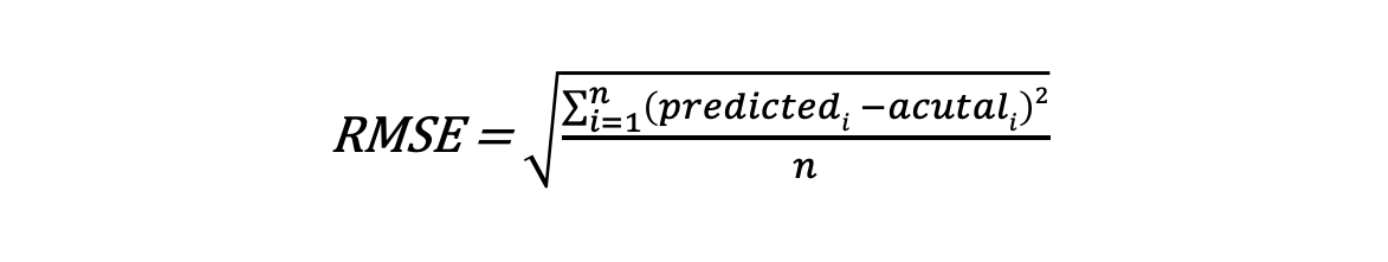

아직 미숙하지만 데이콘 교육자료에 동영상시청하며 하나하나 해보며 많은 교육이 된거 같아 좋다. 다른사람들은 어떻게 했는지 보면서 하나하나 배워 나가 재미있었던거 같다. 많은 배움이 있으면 더욱 설명을 잘써서 올려보도록 하겠다.

출처 : 데이콘 https://dacon.io/competitions/open/235536/talkboard
 - 청청이 :https://hangjastar.tistory.com/162?category=962493
 - Dable  :https://smstudyroom.tistory.com/33?category=926161